In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading and Cleaning
Todo
* save cleaned dataset

In [2]:
df = pd.read_csv('data/df_audio_features_1000')
df = (df
    .assign(song_artist = df['name'] + " by " + df['artist'] + "(" + df['id'] + ")")
    .drop(columns='type')
    .dropna()
    .drop_duplicates()
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434 entries, 0 to 1439
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1434 non-null   object 
 1   artist            1434 non-null   object 
 2   danceability      1434 non-null   float64
 3   energy            1434 non-null   float64
 4   key               1434 non-null   int64  
 5   loudness          1434 non-null   float64
 6   mode              1434 non-null   int64  
 7   speechiness       1434 non-null   float64
 8   acousticness      1434 non-null   float64
 9   instrumentalness  1434 non-null   float64
 10  liveness          1434 non-null   float64
 11  valence           1434 non-null   float64
 12  tempo             1434 non-null   float64
 13  duration_ms       1434 non-null   int64  
 14  time_signature    1434 non-null   int64  
 15  id                1434 non-null   object 
 16  html              1434 non-null   object 


# Pre-processing
Todo
* different scalers

In [3]:
# tests if min/max-values of numerical columns are within limits passed by 
# scale_dict = {'column name 1': (min, max), 'column name 2 : ...}
# all columns not named explicitly are checked against key 'default'
from typing import Mapping
def test_num_data_scale(df_num : pd.DataFrame, scale_dict : Mapping) -> None:
    #desired min/max
    _df_scale = pd.DataFrame(data = scale_dict,
                          index=['min', 'max'])
  
    # actual min/max of data
    _df_num_minmax = df_num.describe().loc[['min', 'max'],:]

    # set min/max default for columns not explicitly named in scale_dict 
    # implicitly creates new columns via new_cols
    new_cols = _df_num_minmax.columns[~_df_num_minmax.columns.isin(_df_scale.columns)]
    _df_scale.loc[:, new_cols] = _df_scale.loc[:, 'default'] 

    _df_scale.drop(columns = 'default', inplace=True)

    assert((_df_scale.shape[1] == _df_num_minmax.shape[1]) and 
        all((_df_scale.loc['min',:] <= _df_num_minmax.loc['min', :]) & \
            (_df_scale.loc['max',:] >= _df_num_minmax.loc['max', :])))

# min max values of features that are not within [0,1] according to
# https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features
from sys import maxsize as sys_maxsize
scale_dict = {'key' : (-1, 11), 
              'loudness' : (-60, 0), 
              'time_signature' : (3, 7), 
              'duration_ms' : (0, sys_maxsize), 
              'tempo' : (0, sys_maxsize),
              'default' : (0, 1)}

from src.utils import get_numerical_columns
df_num = df[get_numerical_columns(df)]
#test_num_data_scale(df_num, scale_dict)  #<<<<<------------test scaling

# set a priori knowledge min/max for proper fitting of the scaler
# instead of using at hand values that might not extend well to future data
df_num_minmax = df_num.describe().loc[['min', 'max'],:]
scale_dict.pop('default', None)
df_num_minmax.loc[:,scale_dict.keys()] = pd.DataFrame(
                                            data = scale_dict, 
                                            columns = scale_dict.keys(), 
                                            index = df_num_minmax.index)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df_num_minmax)

# apply the scaler
df_num_scaled = pd.DataFrame(scaler.transform(df_num), columns=df_num.columns, index=df_num.index)

In [4]:
df_num_scaled.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1.434000e+03,1.434000e+03,1434.000000
mean,0.529702,0.496230,0.513192,0.814870,0.662483,0.113876,0.471413,0.192057,0.159561,0.469110,1.248972e-17,3.162551e-14,0.222455
std,0.242552,0.283048,0.295339,0.116463,0.473028,0.155390,0.376077,0.342248,0.151639,0.298362,3.426436e-18,2.476664e-14,0.111802
min,0.000000,0.000000,0.083333,0.259900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.387292e-18,6.804236e-15,-0.500000
25%,0.360902,0.244212,0.250000,0.750437,0.000000,0.027496,0.083206,0.000000,0.072617,0.201626,9.866755e-18,2.094570e-14,0.250000
50%,0.555506,0.531617,0.500000,0.851008,1.000000,0.045224,0.420681,0.000130,0.100902,0.473275,1.192091e-17,2.534735e-14,0.250000
75%,0.719980,0.735938,0.750000,0.905338,1.000000,0.118804,0.872490,0.165228,0.189049,0.725502,1.469457e-17,3.348339e-14,0.250000
max,1.000000,1.000000,1.000000,1.018083,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.236850e-17,4.137085e-13,0.500000


In [5]:
from sklearn.metrics import pairwise_distances

# metric = ['euclidean', 'manhatten']
def get_distances(df, metric = 'euclidean', labels = None):
    if labels is not None:
        df = df.copy().set_index(labels)
    return pd.DataFrame(pairwise_distances(df, metric = metric), index=df.index, columns=df.index)

# Euclidean (by default)
ecl_dis = get_distances(df_num_scaled, labels = df['song_artist'])

# K-Means

TODO
* automatic selection of number of clusters via inertia & silhouette score

In [6]:
from sklearn.cluster import KMeans

# from scatter plot we can see shit, 
# we are going to assume there can be num_clusters different clusters.
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_num_scaled)

KMeans(n_clusters=7)

In [7]:
cl_pos = pd.DataFrame(kmeans.cluster_centers_)
cl_pos.columns = df_num_scaled.columns
df_num_scaled['clusters'] = kmeans.labels_

In [8]:
df_num_scaled.describe()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,clusters
count,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1434.000000,1.434000e+03,1.434000e+03,1434.000000,1434.000000
mean,0.529702,0.496230,0.513192,0.814870,0.662483,0.113876,0.471413,0.192057,0.159561,0.469110,1.248972e-17,3.162551e-14,0.222455,2.828452
std,0.242552,0.283048,0.295339,0.116463,0.473028,0.155390,0.376077,0.342248,0.151639,0.298362,3.426436e-18,2.476664e-14,0.111802,2.035930
min,0.000000,0.000000,0.083333,0.259900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.387292e-18,6.804236e-15,-0.500000,0.000000
25%,0.360902,0.244212,0.250000,0.750437,0.000000,0.027496,0.083206,0.000000,0.072617,0.201626,9.866755e-18,2.094570e-14,0.250000,1.000000
50%,0.555506,0.531617,0.500000,0.851008,1.000000,0.045224,0.420681,0.000130,0.100902,0.473275,1.192091e-17,2.534735e-14,0.250000,3.000000
75%,0.719980,0.735938,0.750000,0.905338,1.000000,0.118804,0.872490,0.165228,0.189049,0.725502,1.469457e-17,3.348339e-14,0.250000,5.000000
max,1.000000,1.000000,1.000000,1.018083,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.236850e-17,4.137085e-13,0.500000,6.000000


# Visualising Results
Todo
* corr heatmap of features : general and per cluster

Text(0.5, 1.0, 'Looking for a relation between features')

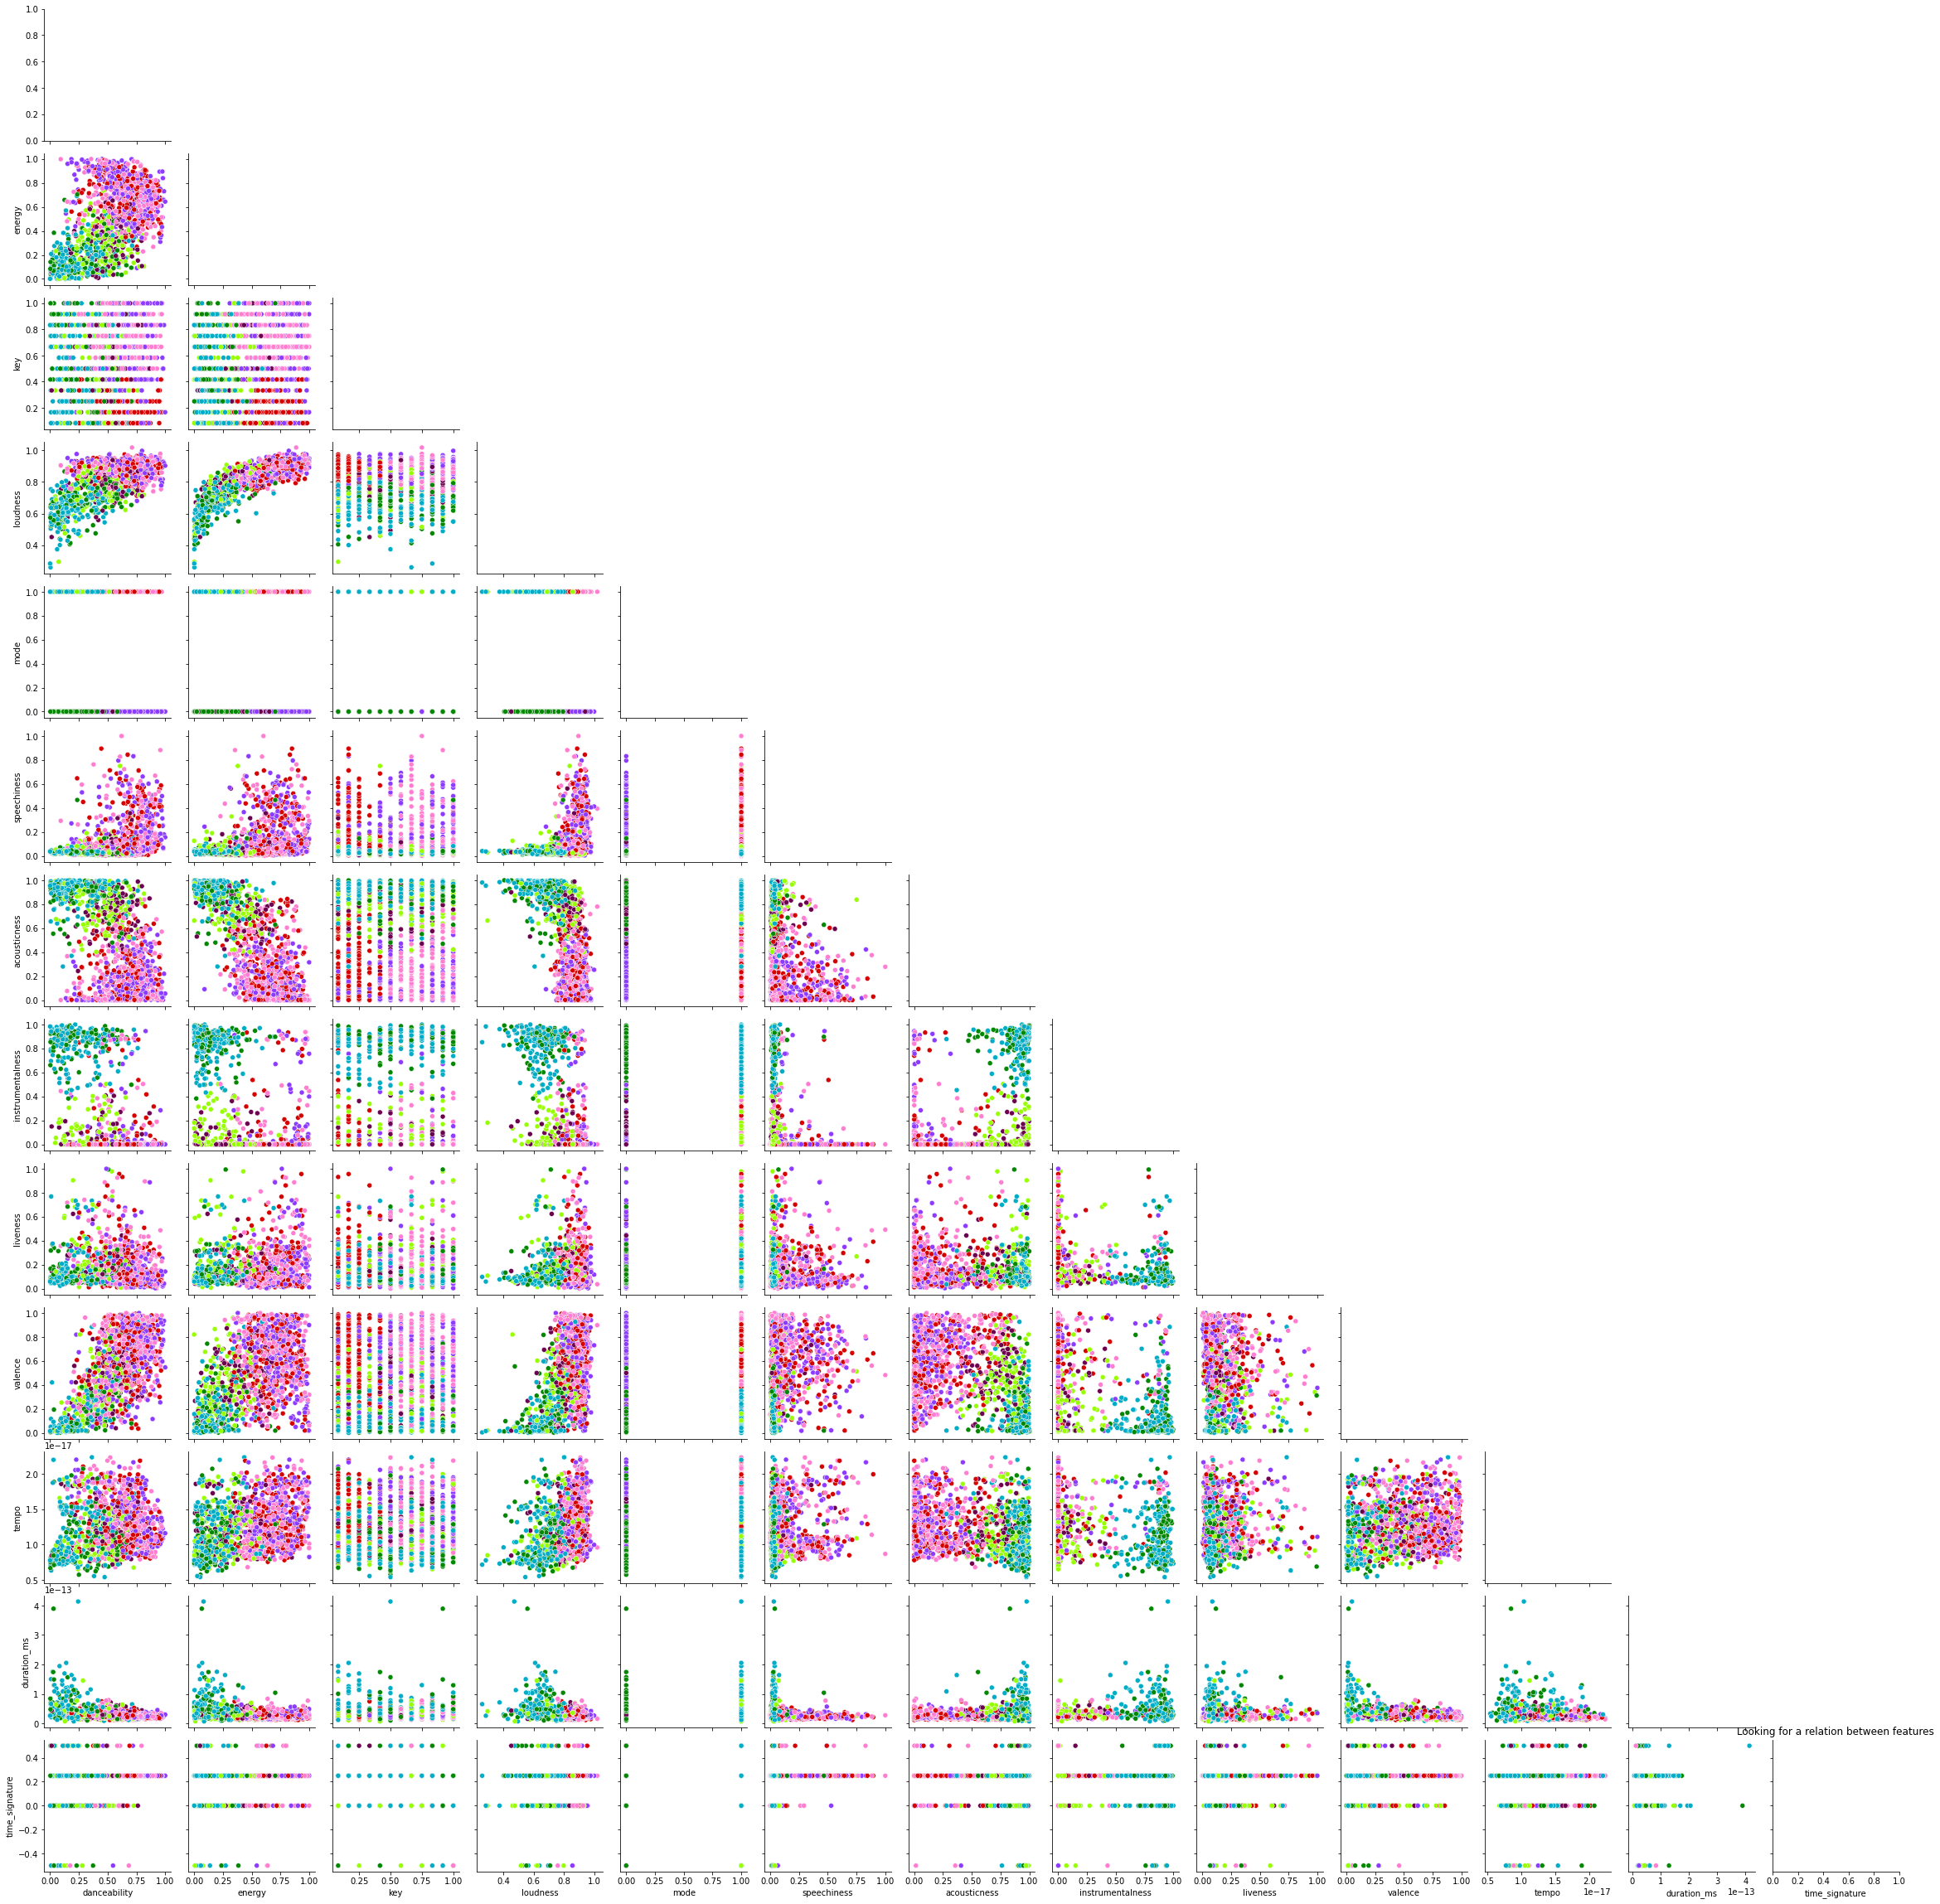

In [9]:
from src.utils import install_pip_pkg
install_pip_pkg({'colorcet'})
import colorcet as cc
import seaborn as sns

# retrospective pairwise scatterplots of all features with clusters as hue
palette = sns.color_palette(cc.glasbey, n_colors=num_clusters)
g = sns.PairGrid(df_num_scaled, hue='clusters', palette = palette, corner=True)
g.map_lower(sns.scatterplot)
plt.title('Looking for a relation between features')

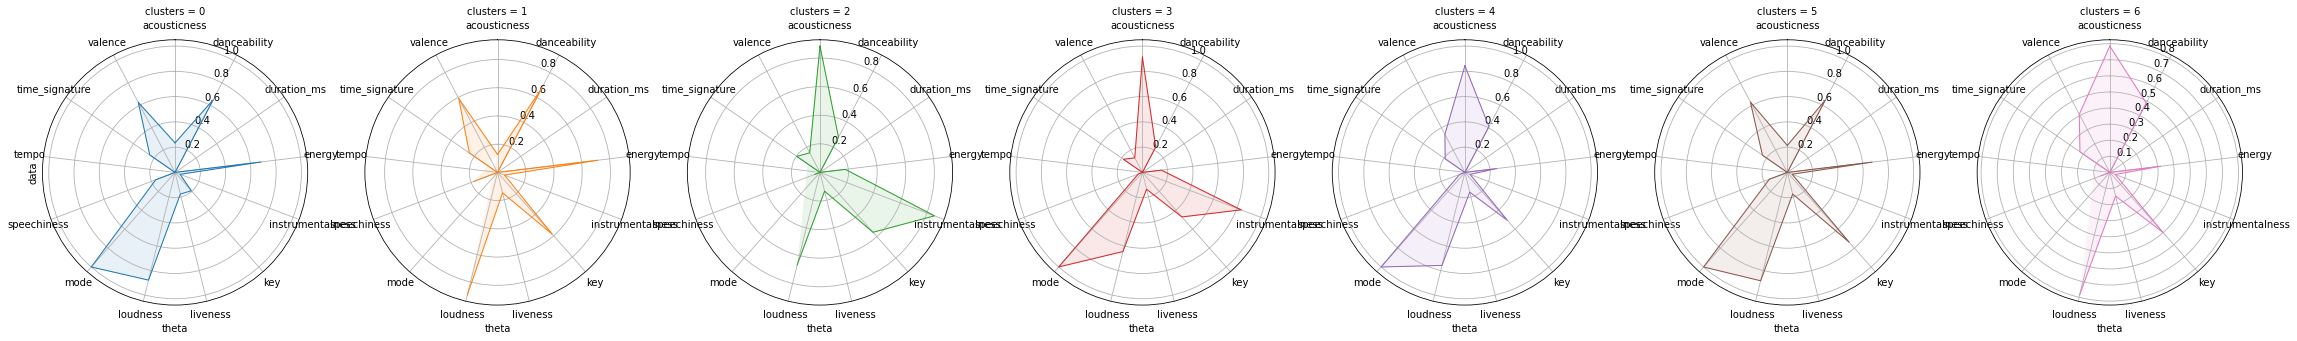

In [19]:
from src.utils import reload_module
reload_module({'name' :'.visualisations', 'package':'src'})
from src.visualisations import spider_plot
spider_plot(cl_pos)

# Metrics
Todo
* get genre from Spotify API
* compare to myJam dataset
* get playlists from Spotify API and count in-cluster-songs occurences


In [ ]:
def metric_compare_genre():
    pass

In [ ]:
def metric_compare_myjam():
    pass

In [ ]:
def metric_compare_playlists():
    pass

# Finalise Playlists
Todo
* get top n songs (i.e. closest to cluster centre) 
* answer: 
    * are Spotify’s audio features able to identify “similar songs”, as defined by humanly detectable criteria?
    * is K-Means a good method to create playlists?  ->no: "similar" != "playlist-member"


In [ ]:
# return the n closest songs to a cluster
# song identifier has to be in the index
# metric = ['euclidean', 'cityblock']; for more see
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
def get_top_songs(n, df_songs, srs_cluster, metric = 'euclidean'):
    from scipy.spatial.distance. import cdist
    from pandas import DataFrame as pd_dataframe
    return pd_dataframe(
                    data = cdist(df_songs, srs_cluster, metric),
                    index = df_songs.index,
                    columns = ['distance']
            ).sort_values(by = 'distance').reset_index()
    